In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_name = "Customer_Segment_For_Application_Data.csv"
#file_name = "IS453 Group Assignment - Bureau Data.csv"
df = pd.read_csv(file_name)

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100041,0,Cash loans,F,N,N,0,112500.0,450000.0,44509.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100088,0,Revolving loans,F,N,N,0,112500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
3,100120,0,Cash loans,F,N,N,0,135000.0,781920.0,28215.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,100140,0,Revolving loans,F,N,N,0,157500.0,675000.0,33750.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create an empty dictionary to store column names and counts
column_non_null_counts = {}

# Iterate over each column and store the count of non-null values in the dictionary
for column in df.columns:
    non_null_count = df[column].count()
    column_non_null_counts[column] = non_null_count

# Sort the dictionary by non-null counts in descending order
sorted_columns = sorted(column_non_null_counts.items(), key=lambda x: x[1], reverse=True)

# Write HTML table to a file
with open("column_counts.html", "w") as f:
    f.write("<html><head><title>Column Counts</title></head><body>")
    f.write("<table>")
    f.write("<tr><th>Column</th><th>Non-null Count</th></tr>")
    for column, count in sorted_columns:
        f.write(f"<tr><td>{column}</td><td>{count}</td></tr>")
    f.write("</table>")
    f.write("</body></html>")

print("HTML file 'column_counts.html' has been generated.")

HTML file 'column_counts.html' has been generated.


In [ ]:
# Total number of rows
total_rows = len(df)

# Total number of unique rows based on SK_ID_CURR
unique_rows = df['SK_ID_CURR'].nunique()

print("Total number of rows:", total_rows)
print("Total number of unique rows based on SK_ID_CURR:", unique_rows)

Total number of rows: 8030
Total number of unique rows based on SK_ID_CURR: 8030


## Determining WOE and Classing

- IV < 0.02: Variable has no predictive power for modeling.
- 0.02 ≤ IV < 0.1: Variable has a weak predictive power.
- 0.1 ≤ IV < 0.3: Variable has a moderate predictive power.
- IV ≥ 0.3: Variable has a strong predictive power.

### Counting IV

In [ ]:
def woe_iv(data : pd.DataFrame, variable_name : str, br : str = 'Bin_Range') -> tuple[float, pd.DataFrame]:
    # data = input dataframe that has already been binned for the predictor variable_name
    # variable_name = predictor variable, not used in this function
    working_data = data.copy()

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data[br] = working_data[br].astype('category')
    miss = 'Missing'
    if miss not in working_data[br].cat.categories:
        working_data[br] = working_data[br].cat.add_categories(miss)
    working_data[br] = working_data[br].fillna(miss)

    variable_data = pd.DataFrame()
    variable_data[br] = working_data[br].cat.categories
    # everything is faster with numpy
    gb = working_data.groupby(br, observed = False)['TARGET']
    c = gb.count().to_numpy()
    variable_data['Count'] = c
    se = gb.sum().to_numpy()
    variable_data['Events'] = se
    ne =  c - se
    variable_data['Non_Events'] = ne
    pe = se / se.sum()
    variable_data['%_of_Events'] = pe
    pne = ne / ne.sum()
    variable_data['%_of_Non_Events'] = pne
    # suppress warning if taking log of zero
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        woe = np.log(pne) - np.log(pe)
    variable_data['WOE'] = woe
    variable_data['IV'] = (pne - pe) * woe

    IV = variable_data['IV'].sum(skipna = True)
    return IV, variable_data

In [ ]:
variable = "COMMONAREA_AVG"
br = "Bin_Range"
bin_count= 20

df_data_working = df.copy()
df_data_working = df_data_working[[variable, 'TARGET']]
df_data_working[br] = pd.qcut(df[variable], q = bin_count, precision = 0, duplicates='drop')


IV, variable_data = woe_iv(df_data_working, variable, br)
average_IV = IV / len(variable_data)  # Calculate average IV

print("Total IV:", IV.round(4))
print("Average IV:", average_IV.round(4))

Total IV: 0.0568
Average IV: 0.0028


### Running graph

In [ ]:
def woe_iv_plot(data : pd.DataFrame, variable_name : str, br : str = 'Bin_Range'):
    # data = input dataframe that has already been binned for the predictor variable_name
    # variable_name = name of predictor variable that has been binned
    IV, variable_data = woe_iv(data, variable_name, br)
    print(f'IV for {variable_name} with {variable_data.shape[0]} bins = {IV:.4f}')
    fig, ax1 = plt.subplots(figsize = (18, 6))
    woe_col = variable_data['WOE']
    sns.lineplot(data = woe_col.iloc[:-1], marker = 'o', sort = False, ax = ax1)
    plt.xticks(rotation = 45, horizontalalignment = 'right')
    # create the scatter plot to plot the Missing WOE data point, if there is any
    last_point = woe_col.shape[0] - 1
    y = woe_col[last_point]
    if not pd.isna(y):
        sns.scatterplot(x = [last_point], y = [y], color = 'b', s = 30, ax = ax1)
    # plot the bin counts
    ax2 = ax1.twinx()
    sns.barplot(x = variable_data[br] , y = variable_data['Count'], alpha = .5, ax = ax2, color = 'deepskyblue')
    plt.title(f'WOE plot for {variable}')
    plt.show()

IV for COMMONAREA_AVG with 20 bins = 0.0568


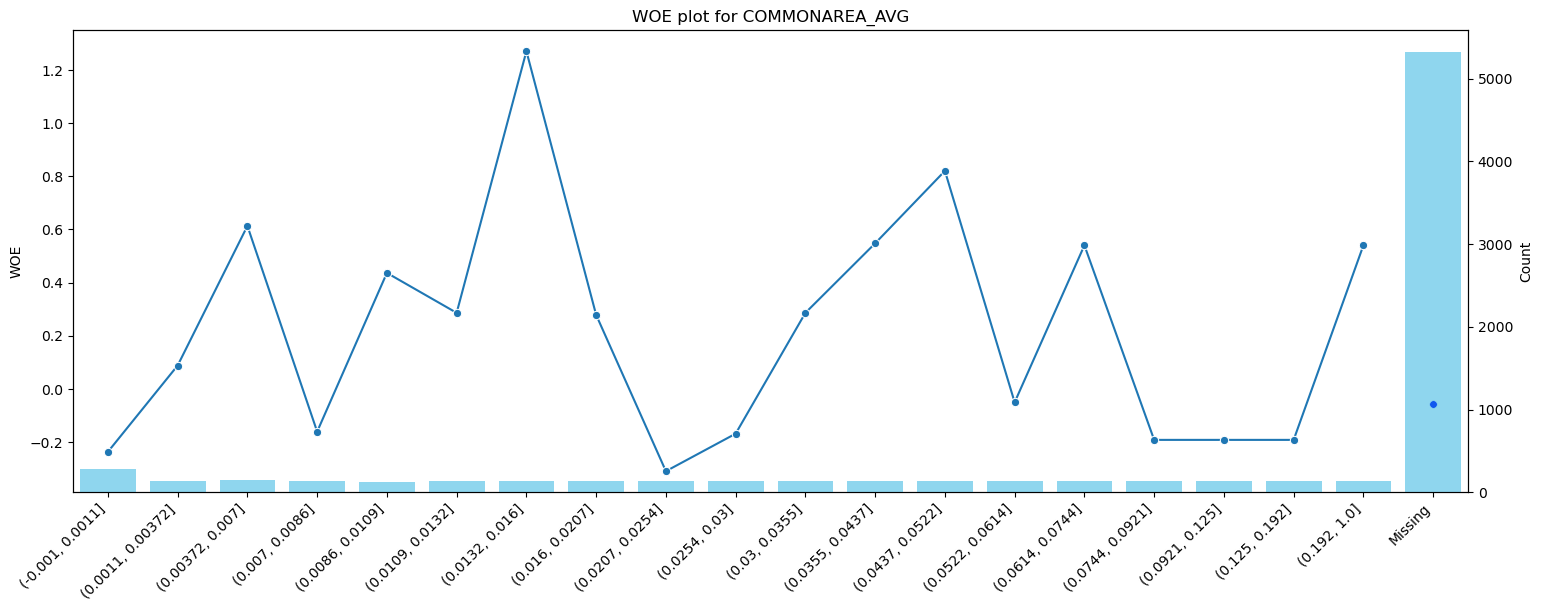

In [ ]:
variable = 'COMMONAREA_AVG'
woe_bin_data = df.loc[:,(variable, 'TARGET')]
woe_bin_data[br] = pd.qcut(df[variable], q = 20, duplicates='drop')
woe_iv_plot(woe_bin_data, variable)
del woe_bin_data # remove variable from memory

### Running the functions together

In [ ]:
#variables = ["COMMONAREA_AVG", "COMMONAREA_MODE", "COMMONAREA_MEDI"]
#variables = ["NONLIVINGAPARTMENTS_AVG", "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAPARTMENTS_MEDI"]
#variables = ["NONLIVINGAREA_AVG", "NONLIVINGAREA_MODE", "NONLIVINGAREA_MEDI"]
#variables = ["BASEMENTAREA_AVG", "BASEMENTAREA_MODE", "BASEMENTAREA_MEDI"]
#variables = ["LANDAREA_AVG", "LANDAREA_MODE", "LANDAREA_MEDI"]
#variables = ["OWN_CAR_AGE", "YEARS_BUILD_AVG", "YEARS_BUILD_MODE", "YEARS_BUILD_MEDI"]
#variables = ["FLOORSMIN_AVG", "FLOORSMIN_MODE", "FLOORSMIN_MEDI"]
#variables = ["FONDKAPREMONT_MODE", "LIVINGAPARTMENTS_AVG", "LIVINGAPARTMENTS_MODE", "LIVINGAPARTMENTS_MEDI"]
#variables = ["LIVINGAPARTMENTS_AVG", "LIVINGAPARTMENTS_MODE", "LIVINGAPARTMENTS_MEDI"]
#variables = ["TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BEGINEXPLUATATION_MEDI", "FLOORSMAX_AVG", "FLOORSMAX_MODE", "FLOORSMAX_MEDI", "LIVINGAREA_AVG", "LIVINGAREA_MODE", "LIVINGAREA_MEDI", "ENTRANCES_AVG", "ENTRANCES_MODE", "ENTRANCES_MEDI", "HOUSETYPE_MODE", "APARTMENTS_AVG", "APARTMENTS_MODE", "APARTMENTS_MEDI", "WALLSMATERIAL_MODE", "ELEVATORS_AVG", "ELEVATORS_MODE", "ELEVATORS_MEDI"]
#variables = ["TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BEGINEXPLUATATION_MEDI", "FLOORSMAX_AVG", "FLOORSMAX_MODE", "FLOORSMAX_MEDI", "LIVINGAREA_AVG", "LIVINGAREA_MODE", "LIVINGAREA_MEDI", "ENTRANCES_AVG", "ENTRANCES_MODE", "ENTRANCES_MEDI", "APARTMENTS_AVG", "APARTMENTS_MODE", "APARTMENTS_MEDI", "ELEVATORS_AVG", "ELEVATORS_MODE", "ELEVATORS_MEDI"]
#variables =  ["AMT_ANNUITY", "AMT_GOODS_PRICE", "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
#variables = ["REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
#variables = ["AMT_INCOME_TOTAL", "AMT_CREDIT"]
variables = [ "LANDAREA_MEDI"]


#variables = ["AMT_ANNUITY", "AMT_GOODS_PRICE"]

bin_count = 20
br = 'Bin_Range'

res = {}
for i in variables:
  df_data_working = df.copy()
  df_data_working = df_data_working[[i, 'TARGET']]
  df_data_working[br] = pd.qcut(df_data_working[i], q = bin_count, precision = 0, duplicates="drop")

  resIV = woe_iv(df_data_working, i, br)[0].round(4)
  res[i] = resIV

print(res)

{'LANDAREA_MEDI': 0.108}


In [ ]:
def woe_iv_categorical(data: pd.DataFrame, variable_name: str, br: str = 'Bin_Range') -> tuple[float, pd.DataFrame]:
    working_data = data.copy()

    # Ensure the Bin_Range column is categorical
    working_data[br] = working_data[br].astype('category')

    # Add 'Missing' category if not present and handle missing values
    miss = 'Missing'
    if miss not in working_data[br].cat.categories:
        working_data[br] = working_data[br].cat.add_categories(miss)
    working_data[br] = working_data[br].fillna(miss)

    # Create a DataFrame to store variable data
    variable_data = pd.DataFrame()
    variable_data[br] = working_data[br].cat.categories

    # Group by Bin_Range and calculate counts of events and non-events
    gb = working_data.groupby(br, observed=False)['TARGET']
    c = gb.count().to_numpy()
    variable_data['Count'] = c
    se = gb.sum().to_numpy()
    variable_data['Events'] = se
    ne = c - se
    variable_data['Non_Events'] = ne

    # Calculate percentage of events and non-events
    pe = se / se.sum()
    pne = ne / ne.sum()
    variable_data['%_of_Events'] = pe
    variable_data['%_of_Non_Events'] = pne

    # Calculate WOE and IV
    with np.errstate(divide='ignore', invalid='ignore'):
        woe = np.log(pne) - np.log(pe)
    variable_data['WOE'] = woe
    variable_data['IV'] = (pne - pe) * woe

    # Sum IV to get total IV
    IV = variable_data['IV'].sum(skipna=True)

    return IV, variable_data


In [ ]:
#variables = ["FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21"]
#variables = ["REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]
#variables = ["CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "WEEKDAY_APPR_PROCESS_START"]
#variables = ["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
#variables = ["NAME_HOUSING_TYPE", "NAME_INCOME_TYPE"]
variables = ["FLAG_OWN_REALTY", "FLAG_OWN_CAR", "NAME_CONTRACT_TYPE"]

br = 'Bin_Range'  # Since we won't be binning categorical variables, you can keep the same name if desired

res = {}
for i in variables:
    df_data_working = df.copy()
    df_data_working = df_data_working[[i, 'TARGET']]
    # Since the variable is categorical, no need to bin it
    # You can directly use the categorical variable itself
    df_data_working[br] = df_data_working[i]

    resIV = woe_iv_categorical(df_data_working, i, br)[0].round(4)
    res[i] = resIV

print(res)


{'FLAG_OWN_REALTY': 0.0, 'FLAG_OWN_CAR': 0.0152, 'NAME_CONTRACT_TYPE': 0.0289}


## Post IV
Here we will use the IV scores to determine whether to drop or not. The rule is simple. Low IV will definitely get canned. Good IV will be going in and overtly good IV will be marked for next round of screening.

#### Candidates Good
- Index: DAYS_EMPLOYED - IV: 0.1184 (0.2784 at 100 bins)
- Index: REGION_POPULATION_RELATIVE - IV: 0.1056
- Index: AMT_CREDIT - IV: 0.1324

#### Candidates to think about
- Index: LANDAREA_MEDI - IV: 0.108
- Index: ENTRANCES_AVG - IV: inf
- Index: ELEVATORS_MEDI - IV: inf
- Index: YEARS_BUILD_AVG - IV: inf
- Index: YEARS_BUILD_MODE - IV: inf
- Index: YEARS_BUILD_MEDI - IV: inf
- Index: AMT_ANNUITY - IV: inf
- Index: AMT_GOODS_PRICE - IV: inf
- Index: FLAG_DOCUMENT_4 - IV: inf
- Index: FLAG_DOCUMENT_6 - IV: inf
- Index: FLAG_DOCUMENT_7 - IV: inf
- Index: FLAG_DOCUMENT_11 - IV: inf
- Index: FLAG_DOCUMENT_15 - IV: inf
- Index: FLAG_DOCUMENT_17 - IV: inf
- Index: FLAG_DOCUMENT_21 - IV: inf
- Index: FLAG_EMP_PHONE - IV: inf
- Index: NAME_INCOME_TYPE - IV: inf


#### Definitely drop
- Index: COMMONAREA_AVG - IV: 0.0568
- Index: COMMONAREA_MODE - IV: 0.0776
- Index: COMMONAREA_MEDI - IV: 0.0779
- Index: NONLIVINGAPARTMENTS_AVG - IV: 0.0345
- Index: NONLIVINGAPARTMENTS_MODE - IV: 0.034
- Index: NONLIVINGAPARTMENTS_MEDI - IV: 0.0379
- Index: NONLIVINGAREA_AVG - IV: 0.0545
- Index: NONLIVINGAREA_MODE - IV: 0.0444
- Index: NONLIVINGAREA_MEDI - IV: 0.0567
- Index: BASEMENTAREA_AVG - IV: 0.0373
- Index: BASEMENTAREA_MODE - IV: 0.0969
- Index: BASEMENTAREA_MEDI - IV: 0.0442
- Index: LANDAREA_AVG - IV: 0.0777
- Index: LANDAREA_MODE - IV: 0.0652
- Index: LANDAREA_MEDI - IV: 0.108
- Index: OWN_CAR_AGE - IV: 0.0748
- Index: FLOORSMIN_AVG - IV: 0.0526
- Index: FLOORSMIN_MODE - IV: 0.0485
- Index: FLOORSMIN_MEDI - IV: 0.0553
- Index: LIVINGAPARTMENTS_AVG - IV: 0.0631
- Index: LIVINGAPARTMENTS_MODE - IV: inf
- Index: LIVINGAPARTMENTS_MEDI - IV: 0.0641
- Index: TOTALAREA_MODE - IV: 0.0528
- Index: YEARS_BEGINEXPLUATATION_AVG - IV: 0.0623
- Index: YEARS_BEGINEXPLUATATION_MODE - IV: 0.0876
- Index: YEARS_BEGINEXPLUATATION_MEDI - IV: 0.0818
- Index: FLOORSMAX_AVG - IV: 0.055
- Index: FLOORSMAX_MODE - IV: 0.0561
- Index: FLOORSMAX_MEDI - IV: 0.0576
- Index: LIVINGAREA_AVG - IV: 0.0709
- Index: LIVINGAREA_MODE - IV: 0.0783
- Index: LIVINGAREA_MEDI - IV: 0.0648
- Index: ENTRANCES_MODE - IV: 0.0448
- Index: ENTRANCES_MEDI - IV: 0.0404
- Index: APARTMENTS_AVG - IV: 0.0899
- Index: APARTMENTS_MODE - IV: 0.0584
- Index: APARTMENTS_MEDI - IV: 0.065
- Index: ELEVATORS_AVG - IV: 0.0474
- Index: ELEVATORS_MODE - IV: 0.0388
- Index: OBS_30_CNT_SOCIAL_CIRCLE - IV: 0.0153
- Index: DEF_30_CNT_SOCIAL_CIRCLE - IV: 0.0027
- Index: OBS_60_CNT_SOCIAL_CIRCLE - IV: 0.0149
- Index: DEF_60_CNT_SOCIAL_CIRCLE - IV: 0.0033
- Index: AMT_REQ_CREDIT_BUREAU_HOUR - IV: 0.0008
- Index: AMT_REQ_CREDIT_BUREAU_DAY - IV: 0.0008
- Index: AMT_REQ_CREDIT_BUREAU_WEEK - IV: 0.0008
- Index: AMT_REQ_CREDIT_BUREAU_MON - IV: 0.0079
- Index: AMT_REQ_CREDIT_BUREAU_QRT - IV: 0.004
- Index: AMT_REQ_CREDIT_BUREAU_YEAR - IV: 0.033
- Index: FLAG_DOCUMENT_2 - IV: 0.0
- Index: FLAG_DOCUMENT_3 - IV: 0.0469
- Index: FLAG_DOCUMENT_5 - IV: 0.001
- Index: FLAG_DOCUMENT_8 - IV: 0.0118
- Index: FLAG_DOCUMENT_9 - IV: 0.0024
- Index: FLAG_DOCUMENT_10 - IV: 0.0
- Index: FLAG_DOCUMENT_12 - IV: 0.0
- Index: FLAG_DOCUMENT_13 - IV: 0.0085
- Index: FLAG_DOCUMENT_14 - IV: 0.0017
- Index: FLAG_DOCUMENT_16 - IV: 0.0017
- Index: FLAG_DOCUMENT_18 - IV: 0.0063
- Index: FLAG_DOCUMENT_19 - IV: 0.0003
- Index: FLAG_DOCUMENT_20 - IV: 0.0003
- Index: REG_REGION_NOT_LIVE_REGION - IV: 0.0143
- Index: REG_REGION_NOT_WORK_REGION - IV: 0.0035
- Index: LIVE_REGION_NOT_WORK_REGION - IV: 0.0003
- Index: REG_CITY_NOT_LIVE_CITY - IV: 0.0274
- Index: REG_CITY_NOT_WORK_CITY - IV: 0.0336
- Index: LIVE_CITY_NOT_WORK_CITY - IV: 0.0168
- Index: CNT_FAM_MEMBERS - IV: 0.0
- Index: REGION_RATING_CLIENT - IV: 0.0711
- Index: REGION_RATING_CLIENT_W_CITY - IV: 0.0747
- Index: HOUR_APPR_PROCESS_START - IV: 0.0348
- Index: FLAG_MOBIL - IV: 0.0
- Index: FLAG_WORK_PHONE - IV: 0.0021
- Index: FLAG_CONT_MOBILE - IV: 0.0
- Index: FLAG_PHONE - IV: 0.0002
- Index: FLAG_EMAIL - IV: 0.0038
- Index: DAYS_BIRTH - IV: 0.072
- Index: DAYS_REGISTRATION - IV: 0.0426
- Index: DAYS_ID_PUBLISH - IV: 0.0377
- Index: NAME_HOUSING_TYPE - IV: 0.0186
- Index: AMT_INCOME_TOTAL - IV: 0.0593
- Index: FLAG_OWN_REALTY - IV: 0.0
- Index: FLAG_OWN_CAR - IV: 0.0152
- Index: NAME_CONTRACT_TYPE - IV: 0.0289


## Cleaning Bureau

In [ ]:
id_list = df["SK_ID_CURR"].tolist()
print(id_list)

[100003, 100041, 100088, 100120, 100140, 100179, 100190, 100289, 100308, 100310, 100344, 100390, 100407, 100474, 100611, 100612, 100686, 100700, 100704, 100749, 100780, 100786, 100788, 100805, 100811, 100855, 100895, 100939, 101060, 101083, 101209, 101229, 101278, 101375, 101390, 101391, 101396, 101405, 101458, 101483, 101524, 101540, 101546, 101619, 101661, 101702, 101709, 101843, 101865, 101888, 101939, 101945, 102071, 102209, 102219, 102229, 102240, 102260, 102263, 102282, 102330, 102350, 102351, 102358, 102412, 102490, 102553, 102587, 102654, 102686, 102739, 102765, 102794, 102893, 102937, 102951, 103006, 103011, 103084, 103093, 103162, 103164, 103183, 103263, 103350, 103379, 103409, 103510, 103519, 103707, 103732, 103741, 103909, 104020, 104038, 104064, 104068, 104100, 104137, 104256, 104268, 104300, 104335, 104362, 104371, 104375, 104392, 104415, 104421, 104495, 104612, 104651, 104709, 104736, 104788, 104885, 104929, 104948, 104967, 105000, 105024, 105076, 105077, 105157, 105201,

In [ ]:
df_bureau = pd.read_csv("IS453 Group Assignment - Bureau Data.csv")
print(df_bureau.head())
df_bureau.info()

   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN         

In [ ]:
filtered_df_bureau = df_bureau[df_bureau['SK_ID_CURR'].isin(id_list)]
missing_ids = set(id_list) - set(filtered_df_bureau['SK_ID_CURR'])

missing_df = pd.DataFrame({'SK_ID_CURR': list(missing_ids)})
for column in df_bureau.columns:
    if column != 'SK_ID_CURR':
        missing_df[column] = None

final_df_bureau = pd.concat([filtered_df_bureau, missing_df], ignore_index=True)

print(final_df_bureau.head())
final_df_bureau.info()

   SK_ID_CURR SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY DAYS_CREDIT  \
0      215354      5714462        Closed      currency 1        -497   
1      215354      5714463        Active      currency 1        -208   
2      215354      5714464        Active      currency 1        -203   
3      215354      5714465        Active      currency 1        -203   
4      215354      5714466        Active      currency 1        -629   

  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                  0               -153.0             -153.0   
1                  0               1075.0                NaN   
2                  0                528.0                NaN   
3                  0                  NaN                NaN   
4                  0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                  0         91323.0   
1                     NaN                  0        22

C:\Users\User\AppData\Local\Temp\ipykernel_1208\2759628428.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df_bureau = pd.concat([filtered_df_bureau, missing_df], ignore_index=True)


In [ ]:
unique_id_count = final_df_bureau['SK_ID_CURR'].nunique()
print("Number of unique SK_ID_CURR values:", unique_id_count)

Number of unique SK_ID_CURR values: 8030


In [ ]:
final_df_bureau.to_csv('Customer_Segment_For_Bureau_Data.csv', index=False)
print("Data has been written to Customer_Segment_For_Bureau_Data.csv")

Data has been written to Customer_Segment_For_Bureau_Data.csv


- **SK_ID_CURR**: Nothing
- **SK_BUREAU_ID**: Nothing
- **CREDIT_ACTIVE**:
- **CREDIT_CURRENCY**:
- **DAYS_CREDIT**: Mean, Median Backup
  - Num: 76, Method: Mean, IV: 0.46497281
- **CREDIT_DAY_OVERDUE**:
  - Num: 56, Method: Count, IV: 0.19207911
- **DAYS_CREDIT_ENDDATE**:
  - Num: 59, Method: Max, IV: 0.41283784
- **DAYS_ENDDATE_FACT**:
  - Num: 76, Method: Mean, IV: 0.50846309
- **AMT_CREDIT_MAX_OVERDUE**:
  - Num: 78, Method: Max, IV: 0.21373575
- **CNT_CREDIT_PROLONG**:
  - No good
- **AMT_CREDIT_SUM**:
  - Num: 67, Method: Standard Deviation, IV: 0.39999495
  - Num: 77, Method: Mean, IV: 0.37187678
- **AMT_CREDIT_SUM_DEBT**:
  - Num: 79, Method: Max, IV: 0.42928086
  - Num: 70, Method: Max, IV: 0.42391998
  - Num: 75, Method: Mean, IV: 0.45918743
- **AMT_CREDIT_SUM_LIMIT**:  Probably drop or feature engineer
  - Num: 47, Method: Max, IV: 0.19162453
- **AMT_CREDIT_SUM_OVERDUE**: Probably drop or feature engineer
  - Num: 56, Method: Count, IV: 0.19207911
- **CREDIT_TYPE**:
  - Failed, retry
- **DAYS_CREDIT_UPDATE**:
  - Num: 79, Method: Max, IV: 0.47726021
- **AMT_ANNUITY**:
  - Num: 75, Method: Mean, IV: 0.17815123
  - Num: 75, Method: Max, IV: 0.17344964

In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Convert 'DAYS_CREDIT' column to numeric data type
final_df_bureau['DAYS_CREDIT'] = pd.to_numeric(final_df_bureau['DAYS_CREDIT'], errors='coerce')

# Now, let's try calculating skewness and kurtosis again
skewness = final_df_bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].apply(skew)
kurtosis = final_df_bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].apply(kurtosis)

# Combine skewness and kurtosis into a DataFrame
symmetry_stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

# Display the symmetry statistics
print(symmetry_stats)


C:\Users\User\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:905: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = f(group)


            Skewness  Kurtosis
SK_ID_CURR                    
100003      0.160766 -1.783529
100041     -0.901423 -0.664393
100088      0.278095 -1.510479
100120      0.000000 -2.000000
100140           NaN       NaN
...              ...       ...
456145     -0.456575 -0.567516
456151     -0.005089 -1.500000
456239     -0.548901 -0.810542
456240      0.000000 -2.000000
456255     -0.660149 -0.629006

[8030 rows x 2 columns]


In [ ]:
import numpy as np

# Assuming skewness and kurtosis are Series containing skewness and kurtosis values for each SK_ID_CURR
skewness_values = skewness.dropna()  # Drop NaN values if any
kurtosis_values = kurtosis.dropna()  # Drop NaN values if any

# Calculate median, standard deviation, and variance of skewness
skewness_median = np.median(skewness_values)
skewness_std = np.std(skewness_values)
skewness_var = np.var(skewness_values)

# Calculate median, standard deviation, and variance of kurtosis
kurtosis_median = np.median(kurtosis_values)
kurtosis_std = np.std(kurtosis_values)
kurtosis_var = np.var(kurtosis_values)

print("Skewness Median:", skewness_median)
print("Skewness Standard Deviation:", skewness_std)
print("Skewness Variance:", skewness_var)

print("Kurtosis Median:", kurtosis_median)
print("Kurtosis Standard Deviation:", kurtosis_std)
print("Kurtosis Variance:", kurtosis_var)


Skewness Median: -0.209632483910179
Skewness Standard Deviation: 0.59257499957614
Skewness Variance: 0.3511451301226623
Kurtosis Median: -1.271223848812096
Kurtosis Standard Deviation: 0.8609948306553225
Kurtosis Variance: 0.7413120984151874


In [ ]:
import pandas as pd
from scipy.stats import mode
import numpy as np

# Initialize an empty dictionary to store IVs for each transformation
iv_results = {}
variable = "AMT_ANNUITY"

# Transforming the "DAYS_CREDIT" variable using different methods
methods = {
    "Mean": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('mean'),
    "Median": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('median'),
    "Min": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('min'),
    "Max": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('max'),
    "Count": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('count'),
    "Standard Deviation": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('std')
}

bin_count = 6
br = 'Bin_Range'
#variable = "DAYS_CREDIT_ENDDATE"

for i in range(5, 80):
    # Iterate over each method and calculate the IV
    for method_name, transformed_data in methods.items():
        # Create a DataFrame to hold the transformed data
        transformed_df = pd.DataFrame({
            variable: transformed_data,
            "SK_ID_CURR": final_df_bureau['SK_ID_CURR']  # Add SK_ID_CURR column for merging
        })

        # Merge with df to add "TARGET" column
        transformed_df = transformed_df.merge(df[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

        transformed_df[variable].fillna(0, inplace=True)

        # Add the 'Bin_Range' column
        transformed_df[br] = pd.qcut(transformed_df[variable], q=i, precision=0, duplicates="drop")

        # Calculate IV using the woe_iv function
        iv = woe_iv(transformed_df, variable, br)[0].round(8)

        # Store the IV in the results dictionary
        iv_results[method_name] = iv

    # Print the IV results for each transformation
    for method_name, iv in iv_results.items():
        print(f"Num: {i}, Method: {method_name}, IV: {iv}")

    iv_results = {}


Num: 5, Method: Mean, IV: 0.03457244
Num: 5, Method: Median, IV: 0.0
Num: 5, Method: Min, IV: 0.0
Num: 5, Method: Max, IV: 0.03409473
Num: 5, Method: Count, IV: 0.02994489
Num: 5, Method: Standard Deviation, IV: 0.02829805
Num: 6, Method: Mean, IV: 0.01341931
Num: 6, Method: Median, IV: 0.0168499
Num: 6, Method: Min, IV: 0.0
Num: 6, Method: Max, IV: 0.0374235
Num: 6, Method: Count, IV: 0.05321577
Num: 6, Method: Standard Deviation, IV: 0.02723927
Num: 7, Method: Mean, IV: 0.00935302
Num: 7, Method: Median, IV: 0.00526198
Num: 7, Method: Min, IV: 0.0
Num: 7, Method: Max, IV: 0.03204301
Num: 7, Method: Count, IV: 0.07154322
Num: 7, Method: Standard Deviation, IV: 0.02877053
Num: 8, Method: Mean, IV: 0.02291861
Num: 8, Method: Median, IV: 0.00459912
Num: 8, Method: Min, IV: 0.0
Num: 8, Method: Max, IV: 0.02543259
Num: 8, Method: Count, IV: 0.06742004
Num: 8, Method: Standard Deviation, IV: 0.01742921
Num: 9, Method: Mean, IV: 0.0335879
Num: 9, Method: Median, IV: 0.00537344
Num: 9, Method

Num: 41, Method: Mean, IV: 0.08506763
Num: 41, Method: Median, IV: 0.01807554
Num: 41, Method: Min, IV: 0.00659046
Num: 41, Method: Max, IV: 0.11954884
Num: 41, Method: Count, IV: 0.11509008
Num: 41, Method: Standard Deviation, IV: 0.07506055
Num: 42, Method: Mean, IV: 0.08525115
Num: 42, Method: Median, IV: 0.0316334
Num: 42, Method: Min, IV: 0.00969239
Num: 42, Method: Max, IV: 0.10626993
Num: 42, Method: Count, IV: 0.1203965
Num: 42, Method: Standard Deviation, IV: 0.0602415
Num: 43, Method: Mean, IV: 0.09356454
Num: 43, Method: Median, IV: 0.01389886
Num: 43, Method: Min, IV: 0.01088855
Num: 43, Method: Max, IV: 0.1344331
Num: 43, Method: Count, IV: 0.1203965
Num: 43, Method: Standard Deviation, IV: 0.06684235
Num: 44, Method: Mean, IV: 0.09362999
Num: 44, Method: Median, IV: 0.01583067
Num: 44, Method: Min, IV: 0.03262235
Num: 44, Method: Max, IV: 0.11522314
Num: 44, Method: Count, IV: 0.1203965
Num: 44, Method: Standard Deviation, IV: 0.08189555
Num: 45, Method: Mean, IV: 0.09115

Num: 77, Method: Mean, IV: 0.14423642
Num: 77, Method: Median, IV: 0.04537239
Num: 77, Method: Min, IV: 0.01454362
Num: 77, Method: Max, IV: 0.13569468
Num: 77, Method: Count, IV: 0.12086831
Num: 77, Method: Standard Deviation, IV: 0.1319381
Num: 78, Method: Mean, IV: inf
Num: 78, Method: Median, IV: 0.1075097
Num: 78, Method: Min, IV: 0.01082298
Num: 78, Method: Max, IV: 0.118138
Num: 78, Method: Count, IV: 0.12086831
Num: 78, Method: Standard Deviation, IV: 0.18154429
Num: 79, Method: Mean, IV: 0.14793697
Num: 79, Method: Median, IV: 0.09445814
Num: 79, Method: Min, IV: 0.00839855
Num: 79, Method: Max, IV: 0.14395405
Num: 79, Method: Count, IV: 0.12086831
Num: 79, Method: Standard Deviation, IV: 0.15930852


In [ ]:
import pandas as pd
from scipy.stats import mode
import numpy as np

# Initialize an empty dictionary to store IVs for each transformation
iv_results = {}
variable = "CREDIT_TYPE"

# Transforming the "DAYS_CREDIT" variable using different methods
methods = {
    "Mean": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('mean'),
    "Median": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('median'),
    "Min": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('min'),
    "Max": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('max'),
    "Count": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('count'),
    "Standard Deviation": final_df_bureau.groupby('SK_ID_CURR')[variable].transform('std')
}

bin_count = 6
br = 'Bin_Range'
#variable = "DAYS_CREDIT_ENDDATE"

for i in range(5, 80):
    # Iterate over each method and calculate the IV
    for method_name, transformed_data in methods.items():
        # Create a DataFrame to hold the transformed data
        transformed_df = pd.DataFrame({
            variable: transformed_data,
            "SK_ID_CURR": final_df_bureau['SK_ID_CURR']  # Add SK_ID_CURR column for merging
        })

        # Merge with df to add "TARGET" column
        transformed_df = transformed_df.merge(df[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

        transformed_df[variable].fillna(0, inplace=True)

        # Add the 'Bin_Range' column
        #transformed_df[br] = pd.qcut(transformed_df[variable], q=i, precision=0, duplicates="drop")
        transformed_df[br] = transformed_df[variable]

        # Calculate IV using the woe_iv function
        iv = woe_iv_categorical(transformed_df, variable, br)

        # Store the IV in the results dictionary
        iv_results[method_name] = iv

    # Print the IV results for each transformation
    for method_name, iv in iv_results.items():
        print(f"Num: {i}, Method: {method_name}, IV: {iv}")

    iv_results = {}


############################################################################

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
import pandas as pd
from scipy.stats import mode
import numpy as np

# Initialize an empty dictionary to store IVs for each transformation
iv_results = {}
variable = "CREDIT_TYPE"

# Transforming the "DAYS_CREDIT" variable using the "Max" method
max_transformed_data = final_df_bureau.groupby('SK_ID_CURR')[variable].transform('max')

bin_count = 6
br = 'Bin_Range'

for i in range(5, 80):
    # Create a DataFrame to hold the transformed data
    transformed_df = pd.DataFrame({
        variable: max_transformed_data,
        "SK_ID_CURR": final_df_bureau['SK_ID_CURR']  # Add SK_ID_CURR column for merging
    })

    # Merge with df to add "TARGET" column
    transformed_df = transformed_df.merge(df[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

    # Calculate Scott's bin width
    bin_width = 3.5 * transformed_df[variable].std() / np.cbrt(i)

    # Add the 'Bin_Range' column using Scott's bin width
    transformed_df[br] = pd.cut(transformed_df[variable], bins=np.arange(transformed_df[variable].min(), transformed_df[variable].max() + bin_width, bin_width))

    # Calculate IV using the woe_iv function
    iv = woe_iv(transformed_df, variable, br)[0].round(8)

    # Store the IV in the results dictionary
    iv_results[i] = i

# Print the IV results for each bin count
for bin_count, iv in iv_results.items():
    print(f"Bin Count: {bin_count}, IV: {iv}")


Bin Count: 5, IV: 5
Bin Count: 6, IV: 6
Bin Count: 7, IV: 7
Bin Count: 8, IV: 8
Bin Count: 9, IV: 9
Bin Count: 10, IV: 10
Bin Count: 11, IV: 11
Bin Count: 12, IV: 12
Bin Count: 13, IV: 13
Bin Count: 14, IV: 14
Bin Count: 15, IV: 15
Bin Count: 16, IV: 16
Bin Count: 17, IV: 17
Bin Count: 18, IV: 18
Bin Count: 19, IV: 19
Bin Count: 20, IV: 20
Bin Count: 21, IV: 21
Bin Count: 22, IV: 22
Bin Count: 23, IV: 23
Bin Count: 24, IV: 24
Bin Count: 25, IV: 25
Bin Count: 26, IV: 26
Bin Count: 27, IV: 27
Bin Count: 28, IV: 28
Bin Count: 29, IV: 29
Bin Count: 30, IV: 30
Bin Count: 31, IV: 31
Bin Count: 32, IV: 32
Bin Count: 33, IV: 33
Bin Count: 34, IV: 34
Bin Count: 35, IV: 35
Bin Count: 36, IV: 36
Bin Count: 37, IV: 37
Bin Count: 38, IV: 38
Bin Count: 39, IV: 39
Bin Count: 40, IV: 40
Bin Count: 41, IV: 41
Bin Count: 42, IV: 42
Bin Count: 43, IV: 43
Bin Count: 44, IV: 44
Bin Count: 45, IV: 45
Bin Count: 46, IV: 46
Bin Count: 47, IV: 47
Bin Count: 48, IV: 48
Bin Count: 49, IV: 49
Bin Count: 50, IV: 5

In [ ]:
final_df_bureau.describe()

,SK_ID_CURR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
count,45048.000000,45048.000000,41355.000000,27237.000000,1.513800e+04,4.421400e+04,3.729100e+04,2.887200e+04,44214.000000,1.057700e+04
mean,278411.484905,-1132.756526,740.357683,-1031.783016,1.166439e+04,5.447426e+05,2.034702e+05,9.514159e+03,21.835966,2.039920e+04
std,102501.617579,791.685259,5259.331644,716.149798,7.797737e+05,1.537081e+06,9.759908e+05,6.568030e+04,2220.486722,1.196769e+05
min,100003.000000,-2922.000000,-41875.000000,-2882.000000,0.000000e+00,0.000000e+00,-6.080686e+05,-3.991669e+05,0.000000,0.000000e+00
25%,190740.000000,-1651.000000,-1064.000000,-1513.000000,0.000000e+00,6.745500e+04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,278982.500000,-973.000000,-252.000000,-900.000000,0.000000e+00,1.708358e+05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
75%,366424.750000,-469.000000,651.000000,-434.000000,0.000000e+00,4.805190e+05,5.595075e+04,0.000000e+00,0.000000,1.988550e+04
max,456255.000000,-2.000000,31198.000000,-3.000000,9.481225e+07,1.469585e+08,5.963769e+07,4.500000e+06,436231.530000,7.331283e+06
